__In this notebook I want to train a model for each stations cluster__ (defined in clustering_the_stations.ipynb).  
Preprocessing pipelines are defined in another file, if I want to improve the models later.

In [22]:
import pandas as pd
import numpy as np
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
import pickle

from termcolor import colored
from velib_prediction.pipeline import load_clean_hist, build_pipe, ohe_pipe
from velib_prediction.utils import create_time_feature
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer


%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
path = '/Users/sebastienvallin/code/Sebastien01/velib_prediction/raw_data/historique_velib_global.csv'
df = load_clean_hist()
df.head()

/Users/sebastienvallin/.pyenv/versions/3.8.12/envs/sebenv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,station_id,time,capacity,temp2m,probarain,weather,wind10m,cluster,docks_available
0,213688169,2022-03-19 17:26:50,35,15.0,0.0,0.0,26.0,555.0,31
1,516709288,2022-03-19 17:26:50,20,15.0,0.0,0.0,26.0,7.0,19
2,36255,2022-03-19 17:26:50,21,15.0,0.0,0.0,26.0,888.0,14
3,37815204,2022-03-19 17:26:50,30,15.0,0.0,0.0,26.0,33.0,22
4,100769544,2022-03-19 17:26:50,45,15.0,0.0,0.0,26.0,8.0,0


Let's try a model on the smallest cluster first

In [3]:
def plot_results(model,X_valid, X_test, y_train, y_test):
    
    def compute_rmse(model,X,y):
        ypred = model.predict(X)
        mse = mean_squared_error(y, ypred)
        return mse**(1/2.0)
    
    train_error = model.evals_result_['validation_0']['rmse']
    valid_error = model.evals_result_['validation_1']['rmse']
    x_axis = list(range(len(train_error)))
    
    valid_rmse = compute_rmse(model,X_valid,y_valid)
    test_rmse = compute_rmse(model,X_test,y_test)
    
    print(f"Train RMSE : {train_error[-1]:.2f}")
    print(f"Valid RMSE : {valid_rmse:.2f}")
    print(f"Test RMSE : {test_rmse:.2f}")
    
    plt.plot(x_axis, train_error, label='training')
    plt.plot(x_axis, valid_error, label='validating') 
    plt.legend()
    

# Test on a unique station to know towards what we can aim

In [152]:
X_full = df.query('station_id == 213688169').drop(columns=['cluster','station_id','capacity'])
y_full = X_full.pop('docks_available')

X_full = create_time_feature(X_full)

X_train, X_test, y_train, y_test = train_test_split(X_full,y_full, train_size=0.7, shuffle=False, random_state=1)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, train_size=0.75)

In [154]:
params=  { 'objective':'reg:squarederror',
             'n_estimators':300,
             'max_depth': 6, 
             'colsample_bylevel':0.7,
             'learning_rate':0.1,
             'random_state':20,
             'gamma': 8
           }

eval_set = [(X_train, y_train), (X_valid, y_valid)]

baseline = xgb.XGBRegressor(**params)
baseline.fit(X_train, y_train, eval_set=eval_set, verbose=10);

[0]	validation_0-rmse:24.67027	validation_1-rmse:24.36162
[10]	validation_0-rmse:8.91999	validation_1-rmse:8.87354
[20]	validation_0-rmse:3.48569	validation_1-rmse:3.53827
[30]	validation_0-rmse:1.70941	validation_1-rmse:1.88441
[40]	validation_0-rmse:1.22449	validation_1-rmse:1.53145
[50]	validation_0-rmse:1.11618	validation_1-rmse:1.46570
[60]	validation_0-rmse:1.08240	validation_1-rmse:1.45267
[70]	validation_0-rmse:1.05190	validation_1-rmse:1.43003
[80]	validation_0-rmse:1.04623	validation_1-rmse:1.43352
[90]	validation_0-rmse:1.03597	validation_1-rmse:1.42368
[100]	validation_0-rmse:1.03434	validation_1-rmse:1.42430
[110]	validation_0-rmse:1.03434	validation_1-rmse:1.42433
[120]	validation_0-rmse:1.03311	validation_1-rmse:1.42377
[130]	validation_0-rmse:1.01816	validation_1-rmse:1.41465
[140]	validation_0-rmse:1.01087	validation_1-rmse:1.41104
[150]	validation_0-rmse:1.01087	validation_1-rmse:1.41104
[160]	validation_0-rmse:1.00803	validation_1-rmse:1.41085
[170]	validation_0-rmse

Train RMSE : 1.00
Valid RMSE : 1.41
Test RMSE : 11.94


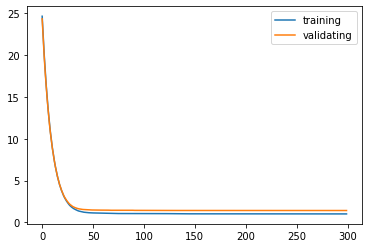

In [155]:
plot_results(baseline,X_valid,X_test,y_valid,y_test)

__Notice the `shuffle=False` when splitting our data.__ I was suspecting a big change in our data.  
We have poor performances when trying to predict recent data, it may be due to meteo changes that we couldn't feed our model with earlier. Indeed I added a new month to my dataset, where the meteo was much better.   
Let's explore our new data to see what could have changed

In [156]:
X_test['pred'] = baseline.predict(X_test)
X_test['true'] = y_test

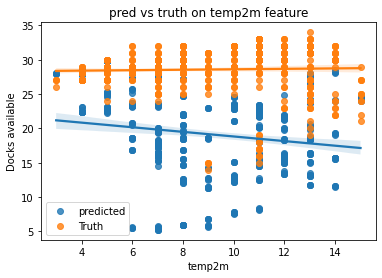

In [157]:
ax = sns.regplot(x = X_test.temp2m, y=X_test.pred, label="predicted")
ax = sns.regplot(x = X_test.temp2m, y=X_test.true, label='Truth')

ax.set(ylabel='Docks available')
plt.legend()
plt.title('pred vs truth on temp2m feature');

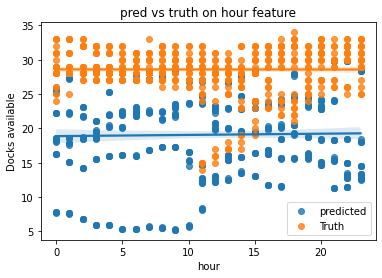

In [158]:
ax = sns.regplot(x = X_test.hour, y=X_test.pred, label="predicted")
ax = sns.regplot(x = X_test.hour, y=X_test.true, label='Truth')

ax.set(ylabel='Docks available')
plt.legend()
plt.title('pred vs truth on hour feature');

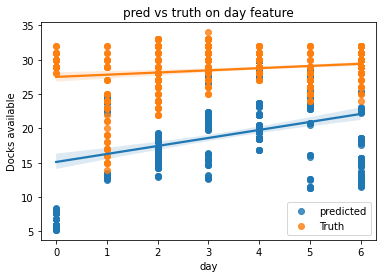

In [159]:
ax = sns.regplot(x = X_test.day, y=X_test.pred, label="predicted")
ax = sns.regplot(x = X_test.day, y=X_test.true, label='Truth')

ax.set(ylabel='Docks available')
plt.legend()
plt.title('pred vs truth on day feature');

There is definitely a drift in our data since the fist training. 

# EDA, here we go again!

In [40]:
pathv3 = '/Users/sebastienvallin/code/Sebastien01/velib_prediction/raw_data/historique_velib_v3.csv'
new_df = load_clean_hist(pathv3)

pathv2 = '/Users/sebastienvallin/code/Sebastien01/velib_prediction/raw_data/historique_velib_v2.csv'
old_df = load_clean_hist(pathv2)

/Users/sebastienvallin/.pyenv/versions/3.8.12/envs/sebenv/lib/python3.8/site-packages/numpy/lib/arraysetops.py:580: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


In [102]:
def plot_comparaison(feature):

    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,3))
    fig.suptitle(feature, fontsize=12)
    
    ax1.hist(new_df[feature])
    ax1.set_title('New data',fontsize=9)
    
    ax2.hist(old_df[feature])
    ax2.set_title('Old data',fontsize=9)

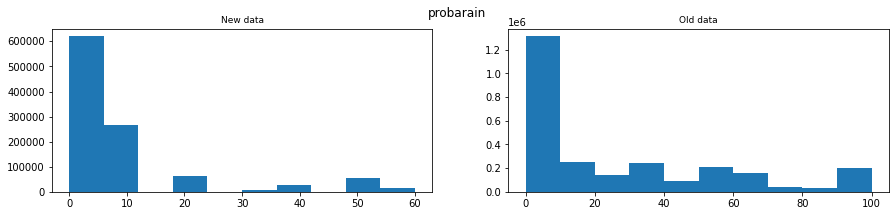

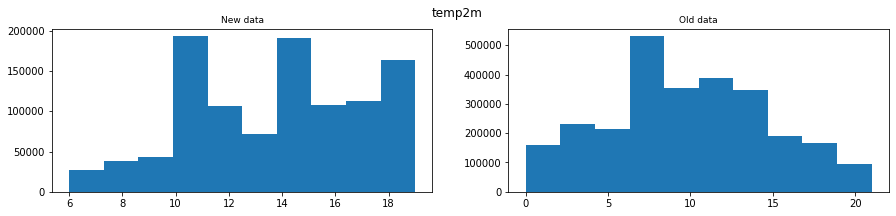

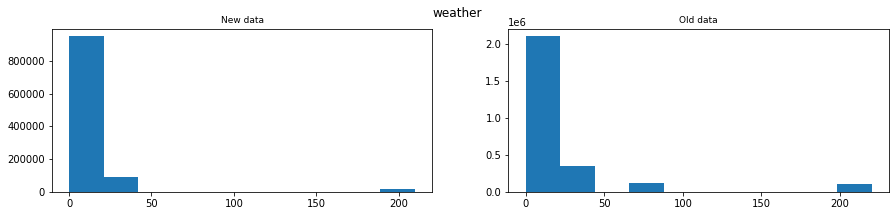

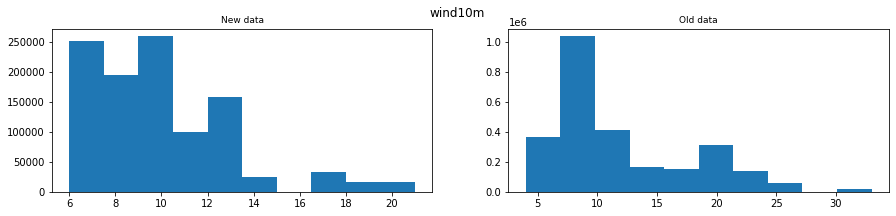

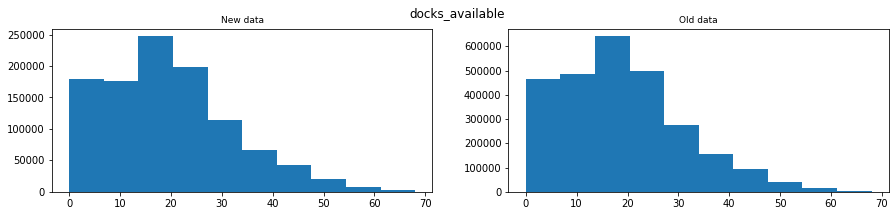

In [103]:
for col in ['probarain','temp2m','weather','wind10m','docks_available']:
    plot_comparaison(col)

# Model tuning 

Trying on cluster n°1 here

In [4]:
X_full = df.query('cluster == 1').drop(columns=['cluster','capacity'])
y_full = X_full.pop('docks_available')

X_full = create_time_feature(X_full)

X_train, X_test, y_train, y_test = train_test_split(X_full,y_full, train_size=0.9, random_state=2)

X_train, X_valid, y_train, y_valid = train_test_split(X_train,y_train, train_size=0.7,  random_state=2)

assert set(X_train.station_id.unique())==set(X_valid.station_id.unique())==set(X_test.station_id.unique())

X_train = ohe_pipe.fit_transform(X_train)
X_test = ohe_pipe.transform(X_test)
X_valid = ohe_pipe.transform(X_valid)

In [195]:
params_3=  { 'objective':'reg:squarederror',
             'n_estimators':3_000,
             'max_depth': 10, 
             'colsample_bylevel':1,
             'learning_rate':0.2,
             'random_state':2,
             #'gamma': 5
           }

eval_set = [(X_train, y_train), (X_valid, y_valid)]

mod3 = xgb.XGBRegressor(**params_3)
mod3.fit(X_train, y_train, eval_set=eval_set, verbose=5);

[0]	validation_0-rmse:29.19048	validation_1-rmse:29.15524
[5]	validation_0-rmse:16.00774	validation_1-rmse:16.00559
[10]	validation_0-rmse:12.53267	validation_1-rmse:12.56999
[15]	validation_0-rmse:11.09919	validation_1-rmse:11.17514
[20]	validation_0-rmse:9.94174	validation_1-rmse:10.04408
[25]	validation_0-rmse:9.10860	validation_1-rmse:9.24026
[30]	validation_0-rmse:8.30738	validation_1-rmse:8.47335
[35]	validation_0-rmse:7.70023	validation_1-rmse:7.90990
[40]	validation_0-rmse:6.97259	validation_1-rmse:7.24768
[45]	validation_0-rmse:6.31537	validation_1-rmse:6.65586
[50]	validation_0-rmse:5.86568	validation_1-rmse:6.25519
[55]	validation_0-rmse:5.50772	validation_1-rmse:5.93858
[60]	validation_0-rmse:5.18608	validation_1-rmse:5.65764
[65]	validation_0-rmse:4.82481	validation_1-rmse:5.34667
[70]	validation_0-rmse:4.44003	validation_1-rmse:5.01887
[75]	validation_0-rmse:4.13673	validation_1-rmse:4.76866
[80]	validation_0-rmse:3.97183	validation_1-rmse:4.63053
[85]	validation_0-rmse:3

[710]	validation_0-rmse:0.42912	validation_1-rmse:2.72736
[715]	validation_0-rmse:0.42483	validation_1-rmse:2.72707
[720]	validation_0-rmse:0.42122	validation_1-rmse:2.72724
[725]	validation_0-rmse:0.41673	validation_1-rmse:2.72715
[730]	validation_0-rmse:0.41239	validation_1-rmse:2.72651
[735]	validation_0-rmse:0.40808	validation_1-rmse:2.72636
[740]	validation_0-rmse:0.40400	validation_1-rmse:2.72565
[745]	validation_0-rmse:0.40045	validation_1-rmse:2.72546
[750]	validation_0-rmse:0.39699	validation_1-rmse:2.72553
[755]	validation_0-rmse:0.39300	validation_1-rmse:2.72510
[760]	validation_0-rmse:0.38976	validation_1-rmse:2.72498
[765]	validation_0-rmse:0.38484	validation_1-rmse:2.72483
[770]	validation_0-rmse:0.38095	validation_1-rmse:2.72471
[775]	validation_0-rmse:0.37645	validation_1-rmse:2.72437
[780]	validation_0-rmse:0.37171	validation_1-rmse:2.72420
[785]	validation_0-rmse:0.36739	validation_1-rmse:2.72421
[790]	validation_0-rmse:0.36337	validation_1-rmse:2.72411
[795]	validati

[1410]	validation_0-rmse:0.12747	validation_1-rmse:2.71767
[1415]	validation_0-rmse:0.12677	validation_1-rmse:2.71766
[1420]	validation_0-rmse:0.12575	validation_1-rmse:2.71758
[1425]	validation_0-rmse:0.12497	validation_1-rmse:2.71753
[1430]	validation_0-rmse:0.12405	validation_1-rmse:2.71756
[1435]	validation_0-rmse:0.12287	validation_1-rmse:2.71748
[1440]	validation_0-rmse:0.12183	validation_1-rmse:2.71745
[1445]	validation_0-rmse:0.12095	validation_1-rmse:2.71740
[1450]	validation_0-rmse:0.12011	validation_1-rmse:2.71734
[1455]	validation_0-rmse:0.11913	validation_1-rmse:2.71730
[1460]	validation_0-rmse:0.11817	validation_1-rmse:2.71733
[1465]	validation_0-rmse:0.11740	validation_1-rmse:2.71726
[1470]	validation_0-rmse:0.11614	validation_1-rmse:2.71721
[1475]	validation_0-rmse:0.11513	validation_1-rmse:2.71719
[1480]	validation_0-rmse:0.11397	validation_1-rmse:2.71723
[1485]	validation_0-rmse:0.11311	validation_1-rmse:2.71727
[1490]	validation_0-rmse:0.11253	validation_1-rmse:2.717

[2105]	validation_0-rmse:0.04403	validation_1-rmse:2.71653
[2110]	validation_0-rmse:0.04366	validation_1-rmse:2.71654
[2115]	validation_0-rmse:0.04337	validation_1-rmse:2.71656
[2120]	validation_0-rmse:0.04292	validation_1-rmse:2.71656
[2125]	validation_0-rmse:0.04264	validation_1-rmse:2.71656
[2130]	validation_0-rmse:0.04238	validation_1-rmse:2.71656
[2135]	validation_0-rmse:0.04209	validation_1-rmse:2.71656
[2140]	validation_0-rmse:0.04174	validation_1-rmse:2.71657
[2145]	validation_0-rmse:0.04141	validation_1-rmse:2.71657
[2150]	validation_0-rmse:0.04115	validation_1-rmse:2.71656
[2155]	validation_0-rmse:0.04087	validation_1-rmse:2.71656
[2160]	validation_0-rmse:0.04052	validation_1-rmse:2.71658
[2165]	validation_0-rmse:0.04022	validation_1-rmse:2.71659
[2170]	validation_0-rmse:0.04000	validation_1-rmse:2.71659
[2175]	validation_0-rmse:0.03970	validation_1-rmse:2.71660
[2180]	validation_0-rmse:0.03944	validation_1-rmse:2.71660
[2185]	validation_0-rmse:0.03921	validation_1-rmse:2.716

[2800]	validation_0-rmse:0.01620	validation_1-rmse:2.71660
[2805]	validation_0-rmse:0.01608	validation_1-rmse:2.71659
[2810]	validation_0-rmse:0.01595	validation_1-rmse:2.71659
[2815]	validation_0-rmse:0.01586	validation_1-rmse:2.71659
[2820]	validation_0-rmse:0.01572	validation_1-rmse:2.71659
[2825]	validation_0-rmse:0.01559	validation_1-rmse:2.71659
[2830]	validation_0-rmse:0.01549	validation_1-rmse:2.71658
[2835]	validation_0-rmse:0.01536	validation_1-rmse:2.71657
[2840]	validation_0-rmse:0.01525	validation_1-rmse:2.71658
[2845]	validation_0-rmse:0.01515	validation_1-rmse:2.71658
[2850]	validation_0-rmse:0.01501	validation_1-rmse:2.71658
[2855]	validation_0-rmse:0.01489	validation_1-rmse:2.71658
[2860]	validation_0-rmse:0.01480	validation_1-rmse:2.71658
[2865]	validation_0-rmse:0.01464	validation_1-rmse:2.71659
[2870]	validation_0-rmse:0.01453	validation_1-rmse:2.71659
[2875]	validation_0-rmse:0.01442	validation_1-rmse:2.71659
[2880]	validation_0-rmse:0.01432	validation_1-rmse:2.716

Train RMSE : 0.01
Valid RMSE : 2.72
Test RMSE : 2.64


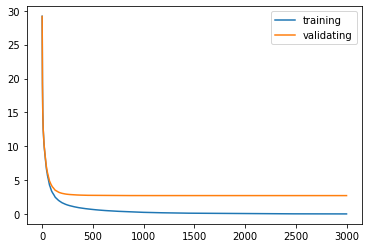

In [196]:
plot_results(mod3,X_valid,X_test,y_valid,y_test) #3.00

Proof that our model is able to capture every parameters of our problem.  
Now that we have overfitted, let's try to reduce the variance

## Fine tunning to reduce variance

I won't be using GridSearch nor RandomSearch for computation reasons, let's try to reduce the variance of our model.  

In [124]:
params=  { 'objective':'reg:squarederror',
             'n_estimators':2_030,
             'max_depth': 18, 
             'colsample_bylevel':0.6,
             'learning_rate':0.02,
             'random_state':20,
             'gamma':4,
             'early_stopping_rounds':5
           }

eval_set = [(X_train, y_train), (X_valid, y_valid)]

mod = xgb.XGBRegressor(**params)
mod.fit(X_train, y_train, eval_set=eval_set, verbose=15);

[0]	validation_0-rmse:34.16820	validation_1-rmse:34.13579
[15]	validation_0-rmse:26.50437	validation_1-rmse:26.50453
[30]	validation_0-rmse:21.04009	validation_1-rmse:21.06115
[45]	validation_0-rmse:17.13589	validation_1-rmse:17.17842
[60]	validation_0-rmse:14.37372	validation_1-rmse:14.44481
[75]	validation_0-rmse:12.36627	validation_1-rmse:12.47001
[90]	validation_0-rmse:10.91928	validation_1-rmse:11.06112
[105]	validation_0-rmse:9.84986	validation_1-rmse:10.01828
[120]	validation_0-rmse:8.99208	validation_1-rmse:9.19518
[135]	validation_0-rmse:8.28857	validation_1-rmse:8.52730
[150]	validation_0-rmse:7.67614	validation_1-rmse:7.94889
[165]	validation_0-rmse:7.14060	validation_1-rmse:7.44834
[180]	validation_0-rmse:6.68815	validation_1-rmse:7.02515
[195]	validation_0-rmse:6.29106	validation_1-rmse:6.66238
[210]	validation_0-rmse:5.93831	validation_1-rmse:6.34027
[225]	validation_0-rmse:5.59901	validation_1-rmse:6.03274
[240]	validation_0-rmse:5.27966	validation_1-rmse:5.74965
[255]	v

Train RMSE : 0.80
Valid RMSE : 2.67
Test RMSE : 2.62


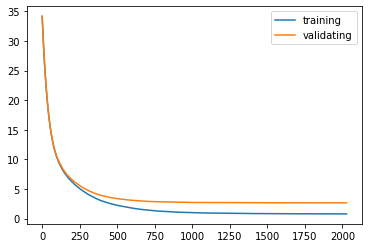

In [125]:
plot_results(mod,X_valid,X_test,y_valid,y_test) #2.53  2.49

In [121]:
params=  { 'objective':'reg:squarederror',
             'n_estimators':3_000,
             'max_depth': 7, 
             'colsample_bylevel':0.8,
             'learning_rate':0.3,
             'random_state':20,
             'gamma':4
            # 'early_stopping_rounds':5
           }

eval_set = [(X_train, y_train), (X_valid, y_valid)]

mod = xgb.XGBRegressor(**params)
mod.fit(X_train, y_train, eval_set=eval_set, verbose=15);

[0]	validation_0-rmse:26.87288	validation_1-rmse:26.82966
[15]	validation_0-rmse:11.93850	validation_1-rmse:12.01732
[30]	validation_0-rmse:9.77067	validation_1-rmse:9.91369
[45]	validation_0-rmse:8.27346	validation_1-rmse:8.48554
[60]	validation_0-rmse:7.15853	validation_1-rmse:7.45108
[75]	validation_0-rmse:6.16805	validation_1-rmse:6.57337
[90]	validation_0-rmse:5.43996	validation_1-rmse:5.96285
[105]	validation_0-rmse:5.01982	validation_1-rmse:5.58112
[120]	validation_0-rmse:4.59821	validation_1-rmse:5.20709
[135]	validation_0-rmse:4.20474	validation_1-rmse:4.88217
[150]	validation_0-rmse:3.90902	validation_1-rmse:4.63461
[165]	validation_0-rmse:3.65454	validation_1-rmse:4.43023
[180]	validation_0-rmse:3.46102	validation_1-rmse:4.26726
[195]	validation_0-rmse:3.33579	validation_1-rmse:4.16880
[210]	validation_0-rmse:3.17136	validation_1-rmse:4.03917
[225]	validation_0-rmse:3.03301	validation_1-rmse:3.93257
[240]	validation_0-rmse:2.92766	validation_1-rmse:3.87143
[255]	validation_0

[2115]	validation_0-rmse:1.04509	validation_1-rmse:2.92207
[2130]	validation_0-rmse:1.04362	validation_1-rmse:2.92158
[2145]	validation_0-rmse:1.04307	validation_1-rmse:2.92143
[2160]	validation_0-rmse:1.04179	validation_1-rmse:2.92108
[2175]	validation_0-rmse:1.04172	validation_1-rmse:2.92107
[2190]	validation_0-rmse:1.04026	validation_1-rmse:2.92085
[2205]	validation_0-rmse:1.03987	validation_1-rmse:2.92080
[2220]	validation_0-rmse:1.03983	validation_1-rmse:2.92076
[2235]	validation_0-rmse:1.03882	validation_1-rmse:2.92047
[2250]	validation_0-rmse:1.03831	validation_1-rmse:2.92043
[2265]	validation_0-rmse:1.03801	validation_1-rmse:2.92054
[2280]	validation_0-rmse:1.03743	validation_1-rmse:2.92023
[2295]	validation_0-rmse:1.03669	validation_1-rmse:2.92023
[2310]	validation_0-rmse:1.03513	validation_1-rmse:2.91998
[2325]	validation_0-rmse:1.03421	validation_1-rmse:2.91989
[2340]	validation_0-rmse:1.03367	validation_1-rmse:2.91964
[2355]	validation_0-rmse:1.03357	validation_1-rmse:2.919

Train RMSE : 1.01
Valid RMSE : 2.91
Test RMSE : 2.87


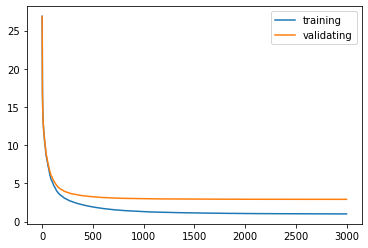

In [122]:
plot_results(mod,X_valid,X_test,y_valid,y_test)

In [126]:
params=  { 'objective':'reg:squarederror',
             'n_estimators':8_000,
             'max_depth': 9, 
             'colsample_bylevel':0.6,
             'learning_rate':0.05,
             'random_state':20,
             'gamma':4,
             'early_stopping_rounds':5
           }

eval_set = [(X_train, y_train), (X_valid, y_valid)]

mod = xgb.XGBRegressor(**params)
mod.fit(X_train, y_train, eval_set=eval_set, verbose=5);

[0]	validation_0-rmse:33.37871	validation_1-rmse:33.34436
[5]	validation_0-rmse:27.52870	validation_1-rmse:27.49654
[10]	validation_0-rmse:23.26355	validation_1-rmse:23.24311
[15]	validation_0-rmse:20.18221	validation_1-rmse:20.17495
[20]	validation_0-rmse:17.96667	validation_1-rmse:17.96555
[25]	validation_0-rmse:16.38962	validation_1-rmse:16.39203
[30]	validation_0-rmse:15.25338	validation_1-rmse:15.26034
[35]	validation_0-rmse:14.43208	validation_1-rmse:14.44880
[40]	validation_0-rmse:13.83625	validation_1-rmse:13.85321
[45]	validation_0-rmse:13.31137	validation_1-rmse:13.33444
[50]	validation_0-rmse:12.91390	validation_1-rmse:12.94157
[55]	validation_0-rmse:12.52298	validation_1-rmse:12.55950
[60]	validation_0-rmse:12.18218	validation_1-rmse:12.22602
[65]	validation_0-rmse:11.91583	validation_1-rmse:11.96195
[70]	validation_0-rmse:11.62939	validation_1-rmse:11.68838
[75]	validation_0-rmse:11.42937	validation_1-rmse:11.49167
[80]	validation_0-rmse:11.19524	validation_1-rmse:11.26535

[705]	validation_0-rmse:2.93841	validation_1-rmse:3.79626
[710]	validation_0-rmse:2.91585	validation_1-rmse:3.78118
[715]	validation_0-rmse:2.89352	validation_1-rmse:3.76585
[720]	validation_0-rmse:2.87551	validation_1-rmse:3.75360
[725]	validation_0-rmse:2.85351	validation_1-rmse:3.73663
[730]	validation_0-rmse:2.82949	validation_1-rmse:3.72030
[735]	validation_0-rmse:2.81113	validation_1-rmse:3.70802
[740]	validation_0-rmse:2.78835	validation_1-rmse:3.68989
[745]	validation_0-rmse:2.77294	validation_1-rmse:3.67841
[750]	validation_0-rmse:2.75282	validation_1-rmse:3.66348
[755]	validation_0-rmse:2.72966	validation_1-rmse:3.64736
[760]	validation_0-rmse:2.71064	validation_1-rmse:3.63375
[765]	validation_0-rmse:2.69727	validation_1-rmse:3.62345
[770]	validation_0-rmse:2.68792	validation_1-rmse:3.61758
[775]	validation_0-rmse:2.67551	validation_1-rmse:3.60918
[780]	validation_0-rmse:2.66694	validation_1-rmse:3.60377
[785]	validation_0-rmse:2.65192	validation_1-rmse:3.59363
[790]	validati

[1405]	validation_0-rmse:1.64445	validation_1-rmse:3.00683
[1410]	validation_0-rmse:1.64079	validation_1-rmse:3.00557
[1415]	validation_0-rmse:1.63479	validation_1-rmse:3.00193
[1420]	validation_0-rmse:1.63044	validation_1-rmse:2.99942
[1425]	validation_0-rmse:1.62350	validation_1-rmse:2.99619
[1430]	validation_0-rmse:1.61991	validation_1-rmse:2.99418
[1435]	validation_0-rmse:1.61642	validation_1-rmse:2.99298
[1440]	validation_0-rmse:1.61298	validation_1-rmse:2.99130
[1445]	validation_0-rmse:1.60838	validation_1-rmse:2.98877
[1450]	validation_0-rmse:1.60455	validation_1-rmse:2.98679
[1455]	validation_0-rmse:1.60061	validation_1-rmse:2.98520
[1460]	validation_0-rmse:1.59744	validation_1-rmse:2.98419
[1465]	validation_0-rmse:1.59407	validation_1-rmse:2.98295
[1470]	validation_0-rmse:1.59152	validation_1-rmse:2.98201
[1475]	validation_0-rmse:1.58716	validation_1-rmse:2.97946
[1480]	validation_0-rmse:1.58396	validation_1-rmse:2.97769
[1485]	validation_0-rmse:1.58021	validation_1-rmse:2.975

[2100]	validation_0-rmse:1.27264	validation_1-rmse:2.84139
[2105]	validation_0-rmse:1.27105	validation_1-rmse:2.84083
[2110]	validation_0-rmse:1.27009	validation_1-rmse:2.84050
[2115]	validation_0-rmse:1.26803	validation_1-rmse:2.83998
[2120]	validation_0-rmse:1.26618	validation_1-rmse:2.83956
[2125]	validation_0-rmse:1.26365	validation_1-rmse:2.83832
[2130]	validation_0-rmse:1.26216	validation_1-rmse:2.83781
[2135]	validation_0-rmse:1.26035	validation_1-rmse:2.83739
[2140]	validation_0-rmse:1.25899	validation_1-rmse:2.83696
[2145]	validation_0-rmse:1.25618	validation_1-rmse:2.83594
[2150]	validation_0-rmse:1.25506	validation_1-rmse:2.83559
[2155]	validation_0-rmse:1.25380	validation_1-rmse:2.83542
[2160]	validation_0-rmse:1.25210	validation_1-rmse:2.83470
[2165]	validation_0-rmse:1.25003	validation_1-rmse:2.83389
[2170]	validation_0-rmse:1.24912	validation_1-rmse:2.83368
[2171]	validation_0-rmse:1.24887	validation_1-rmse:2.83368


Train RMSE : 1.25
Valid RMSE : 2.83
Test RMSE : 2.76


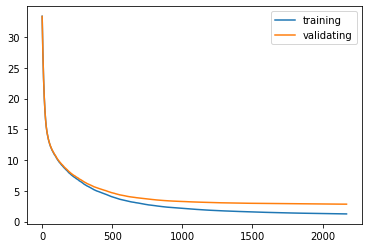

In [127]:
plot_results(mod,X_valid,X_test,y_valid,y_test) 

This model reaches one of the lowest RMSE on test set with a higher training RMSE than usual. That means it is better at generalizing

### Cross validating

In [134]:
dmatrix = xgb.DMatrix(data=X_train, label=y_train)

params_1=  { 'objective':'reg:squarederror',
             'max_depth': 9, 
             'colsample_bylevel':0.6,
             'learning_rate':0.05,
             'random_state':20,
             'gamma':4
           }

cv_results_1 = xgb.cv(dtrain=dmatrix, 
                    params=params_1, 
                    nfold=5, 
                    as_pandas=True,
                    metrics={'rmse'},
                    num_boost_round=2_100, 
                    verbose_eval=5,
                    early_stopping_rounds=5,
                    seed=20)

[0]	train-rmse:33.37951+0.03432	test-rmse:33.38056+0.14708
[5]	train-rmse:27.54145+0.03389	test-rmse:27.54798+0.12594
[10]	train-rmse:23.27015+0.03163	test-rmse:23.29046+0.11716
[15]	train-rmse:20.18755+0.03077	test-rmse:20.22352+0.09667
[20]	train-rmse:17.97689+0.03568	test-rmse:18.02522+0.09712
[25]	train-rmse:16.40789+0.02068	test-rmse:16.47030+0.08723
[30]	train-rmse:15.27639+0.02419	test-rmse:15.35402+0.06372
[35]	train-rmse:14.43521+0.01740	test-rmse:14.52331+0.06098
[40]	train-rmse:13.79362+0.03621	test-rmse:13.89629+0.06123
[45]	train-rmse:13.27447+0.03698	test-rmse:13.38524+0.04401
[50]	train-rmse:12.86699+0.02106	test-rmse:12.98525+0.05614
[55]	train-rmse:12.51362+0.01830	test-rmse:12.63780+0.05209
[60]	train-rmse:12.20332+0.02232	test-rmse:12.33907+0.05352
[65]	train-rmse:11.92942+0.02215	test-rmse:12.07473+0.06891
[70]	train-rmse:11.68269+0.03320	test-rmse:11.83963+0.07675
[75]	train-rmse:11.45017+0.03967	test-rmse:11.61215+0.08531
[80]	train-rmse:11.25065+0.04800	test-rmse

[695]	train-rmse:2.95056+0.04080	test-rmse:4.08166+0.08624
[700]	train-rmse:2.92864+0.03857	test-rmse:4.06566+0.08473
[705]	train-rmse:2.90981+0.03656	test-rmse:4.05194+0.08460
[710]	train-rmse:2.89086+0.03735	test-rmse:4.03900+0.08485
[715]	train-rmse:2.87118+0.03547	test-rmse:4.02544+0.08359
[720]	train-rmse:2.85025+0.03350	test-rmse:4.01089+0.08009
[725]	train-rmse:2.83063+0.03071	test-rmse:3.99674+0.07676
[730]	train-rmse:2.81235+0.02883	test-rmse:3.98360+0.07607
[735]	train-rmse:2.79444+0.02659	test-rmse:3.97129+0.07363
[740]	train-rmse:2.77871+0.02383	test-rmse:3.96090+0.06965
[745]	train-rmse:2.76384+0.02197	test-rmse:3.95040+0.06730
[750]	train-rmse:2.74817+0.02159	test-rmse:3.93880+0.06545
[755]	train-rmse:2.72831+0.02353	test-rmse:3.92581+0.06348
[760]	train-rmse:2.71337+0.02437	test-rmse:3.91579+0.06226
[765]	train-rmse:2.69722+0.02447	test-rmse:3.90493+0.06084
[770]	train-rmse:2.68007+0.02558	test-rmse:3.89381+0.05951
[775]	train-rmse:2.66695+0.02515	test-rmse:3.88520+0.060

[1385]	train-rmse:1.61735+0.01656	test-rmse:3.29504+0.05180
[1390]	train-rmse:1.61283+0.01619	test-rmse:3.29323+0.05179
[1395]	train-rmse:1.60831+0.01566	test-rmse:3.29088+0.05174
[1400]	train-rmse:1.60431+0.01563	test-rmse:3.28905+0.05140
[1405]	train-rmse:1.59938+0.01524	test-rmse:3.28668+0.05095
[1410]	train-rmse:1.59478+0.01545	test-rmse:3.28440+0.05085
[1415]	train-rmse:1.58991+0.01487	test-rmse:3.28229+0.05091
[1420]	train-rmse:1.58642+0.01470	test-rmse:3.28078+0.05084
[1425]	train-rmse:1.58231+0.01460	test-rmse:3.27890+0.05123
[1430]	train-rmse:1.57855+0.01425	test-rmse:3.27717+0.05110
[1435]	train-rmse:1.57456+0.01397	test-rmse:3.27521+0.05125
[1440]	train-rmse:1.57066+0.01425	test-rmse:3.27350+0.05093
[1445]	train-rmse:1.56681+0.01450	test-rmse:3.27152+0.05073
[1450]	train-rmse:1.56299+0.01481	test-rmse:3.26993+0.05039
[1455]	train-rmse:1.55906+0.01493	test-rmse:3.26814+0.05006
[1460]	train-rmse:1.55548+0.01483	test-rmse:3.26646+0.05030
[1465]	train-rmse:1.55150+0.01482	test-r

[2070]	train-rmse:1.23035+0.01083	test-rmse:3.13441+0.05056
[2075]	train-rmse:1.22880+0.01062	test-rmse:3.13392+0.05045
[2080]	train-rmse:1.22721+0.01035	test-rmse:3.13331+0.05049
[2085]	train-rmse:1.22558+0.01004	test-rmse:3.13281+0.05053
[2090]	train-rmse:1.22415+0.01006	test-rmse:3.13237+0.05059
[2095]	train-rmse:1.22252+0.00989	test-rmse:3.13183+0.05058
[2099]	train-rmse:1.22135+0.00947	test-rmse:3.13141+0.05066


Training RMSE : 1.22
Validating RMSE : 3.13


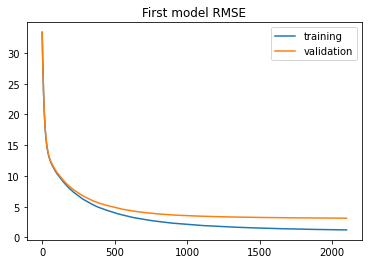

In [135]:
training_error_1 = cv_results_1['train-rmse-mean']
valid_error_1 = cv_results_1['test-rmse-mean']
x_axis = list(range(0,len(training_error_1)))

plt.title('First model RMSE')
plt.plot(x_axis,training_error_1, label='training')
plt.plot(x_axis,valid_error_1, label='validation')
plt.legend(loc="upper right");

print(f"Training RMSE : {training_error_1.iloc[-1]:.2f}")
print(f"Validating RMSE : {valid_error_1.iloc[-1]:.2f}")

# Train and export pipelines

In [186]:
def train_one_model(cluster, n_estimators=3_000):
    
    print('\n')
    print(colored('='*50,'blue'))
    print(f"Fitting cluster n° {cluster}")
    
    X = df.query(f'cluster == {cluster}').drop(columns=['cluster','capacity'])
    y = X.pop('docks_available')

    X = create_time_feature(X)
    X.columns = ['station_id', 'temp2m', 'probarain', 'weather', 'wind10m',
                 'month', 'hour', 'day', 'minute']

    X_train, X_valid, y_train, y_valid = train_test_split(X,y, train_size=0.8)
    
    pipe = build_pipe(n_estimators)
    
    pipe.fit(X_train,y_train)
    
    ypred = pipe.predict(X_valid)
    mse = mean_squared_error(y_valid, ypred)
    print("RMSE: %.2f" % (mse**(1/2.0)))
    
    return pipe # Fitted !

In [190]:
save_path = '/Users/sebastienvallin/code/Sebastien01/velib_prediction/velib_prediction/models'

for i in df.cluster.unique():

    # Export pipeline as pickle file
    with open(f"{save_path}/docks_cl_{int(i)}.pkl", "wb") as file:
        pickle.dump(train_one_model(i,2_200), file)



Fitting cluster n° 555.0
RMSE: 1.59


Fitting cluster n° 7.0
RMSE: 1.59


Fitting cluster n° 888.0
RMSE: 1.29


Fitting cluster n° 33.0
RMSE: 1.93


Fitting cluster n° 8.0
RMSE: 2.17


Fitting cluster n° 3.0
RMSE: 2.21


Fitting cluster n° 88.0
RMSE: 1.46


Fitting cluster n° 4.0
RMSE: 1.85


Fitting cluster n° 1.0
RMSE: 2.41


Fitting cluster n° 55.0
RMSE: 1.72


Fitting cluster n° 0.0
RMSE: 1.64


Fitting cluster n° 2.0
RMSE: 2.16


Fitting cluster n° 6.0
RMSE: 2.22


Fitting cluster n° 11.0
RMSE: 1.60


## Trying a lighter model

In [33]:
params=  { 'objective':'reg:squarederror',
             'n_estimators':1_200,
             'max_depth': 8, 
             'colsample_bylevel':0.9,
             'learning_rate':0.3,
             'random_state':20,
             'gamma':2,
           }

eval_set = [(X_train, y_train), (X_valid, y_valid)]

mod = xgb.XGBRegressor(**params)
mod.fit(X_train, y_train, eval_set=eval_set, verbose=5);

[0]	validation_0-rmse:26.72427	validation_1-rmse:26.70180
[5]	validation_0-rmse:14.40226	validation_1-rmse:14.41150
[10]	validation_0-rmse:12.24514	validation_1-rmse:12.29135
[15]	validation_0-rmse:10.81325	validation_1-rmse:10.88165
[20]	validation_0-rmse:9.95512	validation_1-rmse:10.06909
[25]	validation_0-rmse:9.00687	validation_1-rmse:9.16183
[30]	validation_0-rmse:8.28887	validation_1-rmse:8.47583
[35]	validation_0-rmse:7.78071	validation_1-rmse:8.01134
[40]	validation_0-rmse:7.19605	validation_1-rmse:7.49153
[45]	validation_0-rmse:6.78847	validation_1-rmse:7.12010
[50]	validation_0-rmse:6.33654	validation_1-rmse:6.70295
[55]	validation_0-rmse:6.04627	validation_1-rmse:6.42976
[60]	validation_0-rmse:5.66971	validation_1-rmse:6.08508
[65]	validation_0-rmse:5.33464	validation_1-rmse:5.79068
[70]	validation_0-rmse:5.05089	validation_1-rmse:5.54401
[75]	validation_0-rmse:4.79159	validation_1-rmse:5.33214
[80]	validation_0-rmse:4.56994	validation_1-rmse:5.13699
[85]	validation_0-rmse:4

[710]	validation_0-rmse:0.98129	validation_1-rmse:2.87777
[715]	validation_0-rmse:0.97734	validation_1-rmse:2.87636
[720]	validation_0-rmse:0.97305	validation_1-rmse:2.87449
[725]	validation_0-rmse:0.96914	validation_1-rmse:2.87319
[730]	validation_0-rmse:0.96554	validation_1-rmse:2.87252
[735]	validation_0-rmse:0.96280	validation_1-rmse:2.87185
[740]	validation_0-rmse:0.95850	validation_1-rmse:2.87114
[745]	validation_0-rmse:0.95439	validation_1-rmse:2.87097
[750]	validation_0-rmse:0.95203	validation_1-rmse:2.87036
[755]	validation_0-rmse:0.94859	validation_1-rmse:2.86968
[760]	validation_0-rmse:0.94523	validation_1-rmse:2.86907
[765]	validation_0-rmse:0.94355	validation_1-rmse:2.86878
[770]	validation_0-rmse:0.94018	validation_1-rmse:2.86832
[775]	validation_0-rmse:0.93629	validation_1-rmse:2.86793
[780]	validation_0-rmse:0.93371	validation_1-rmse:2.86692
[785]	validation_0-rmse:0.93064	validation_1-rmse:2.86621
[790]	validation_0-rmse:0.92849	validation_1-rmse:2.86612
[795]	validati

Train RMSE : 0.79
Valid RMSE : 2.84
Test RMSE : 2.80


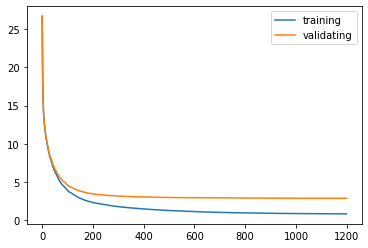

In [34]:
plot_results(mod,X_valid,X_test,y_valid,y_test) 

In [23]:
def train_one_model(cluster, params):
    
    print('\n')
    print(colored('='*50,'blue'))
    print(f"Fitting cluster n° {cluster}")
    
    X = df.query(f'cluster == {cluster}').drop(columns=['cluster','capacity'])
    y = X.pop('docks_available')

    X = create_time_feature(X)
    X.columns = ['station_id', 'temp2m', 'probarain', 'weather', 'wind10m',
                 'month', 'hour', 'day', 'minute']

    X_train, X_valid, y_train, y_valid = train_test_split(X,y, train_size=0.8)
    
    pipe = build_pipe(params)
    
    pipe.fit(X_train,y_train)
    
    ypred = pipe.predict(X_valid)
    mse = mean_squared_error(y_valid, ypred)
    print("RMSE: %.2f" % (mse**(1/2.0)))
    
    return pipe # Fitted !

In [35]:
save_path = '/Users/sebastienvallin/code/Sebastien01/velib_prediction/velib_prediction/models'

params=  { 'objective':'reg:squarederror',
             'n_estimators':650,
             'max_depth': 8, 
             'colsample_bylevel':0.9,
             'learning_rate':0.3,
             'random_state':20,
             'gamma':2,
           }


for i in df.cluster.unique():

    # Export pipeline as pickle file
    with open(f"{save_path}/docks_cl_{int(i)}.pkl", "wb") as file:
        pickle.dump(train_one_model(i,params), file)



Fitting cluster n° 555.0
RMSE: 1.58


Fitting cluster n° 7.0
RMSE: 1.49


Fitting cluster n° 888.0
RMSE: 1.26


Fitting cluster n° 33.0
RMSE: 1.93


Fitting cluster n° 8.0
RMSE: 2.16


Fitting cluster n° 3.0
RMSE: 2.25


Fitting cluster n° 88.0
RMSE: 1.36


Fitting cluster n° 4.0
RMSE: 1.82


Fitting cluster n° 1.0
RMSE: 2.58


Fitting cluster n° 55.0
RMSE: 1.66


Fitting cluster n° 0.0
RMSE: 1.62


Fitting cluster n° 2.0
RMSE: 2.03


Fitting cluster n° 6.0
RMSE: 2.18


Fitting cluster n° 11.0
RMSE: 1.63
